<header style="width:100%;position:relative">
  <div style="width:80%;float:right;">
    <h1>Challenge Loan Approval Prediction in Pennsylvania</h1>
    <h3>Carga y limpieza de los datos</h3>
    <h5>Grupo 2</h5>
  </div>
        <img style="width:15%;" src="./images/logo.jpg" alt="UPM" />
</header>


# Índice

1. [Importar librerias](#1.-Importar-librerias)  
2. [Funciones auxiliares](#2.-Funciones-auxiliares)  
3. [Carga del Dataset](#3.-Carga-del-Dataset)  
4. [Limpieza de los datos](#4.-Limpieza-de-los-datos)  
   * 4.1 [Estudio de las columnas](##4.1-Estudio-de-las-columnas)
   * 4.2 [Tratamiento de los duplicados y de los nulos](##4.2-Tratamiento-de-los-duplicados-y-de-los-nulos)
   * 4.3 [Tratamiento de las variables categóricas](##4.3-Tratamiento-de-las-variables-categoricas)
      * 4.3.1 [Tratamiento de las variables categóricas binarias](###4.3.1-Tratamiento-de-las-variables-categoricas-binarias)
      * 4.3.2 [Tratamiento de las variables categóricas no binarias](###4.3.2-Tratamiento-de-las-variables-categoricas-no-binarias)
5. [Correlacion](#5.-Correlacion)  
6. [Codificacion One-Hot](#6.-Codificacion-One-Hot)  
7. [Create Test](#7.-Create-Test)  
8. [Exportar CSV](#8.-Exportar-CSV)
9. [Referencias](#9.-Referencias)


# 1. Importar librerias

In [5]:
import pandas as pd
import numpy as np

from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

# 2. Funciones auxiliares

In [7]:
def extract_month(date, mode=0):
    if pd.isna(date):
        return mode
    return datetime.strptime(date, '%d-%b-%y').month

In [8]:
def month_to_quarter(month):
    if month == 0:
        return 0
    return np.ceil(month / 3).astype(int)

# 3. Carga del Dataset

In [10]:
url = "data/train.csv" 
data = pd.read_csv(url)
df = data.copy()

url2 = "data/test_nolabel.csv"
df_test = pd.read_csv(url2)

Configuramos Pandas para mostrar todas las columnas de un DataFrame al imprimirlo, y luego mostramos las primeras filas del DataFrame df.

In [12]:
pd.set_option('display.max_columns', None)
df.head()

,id,LoanNr_ChkDgt,Name,City,State,Bank,BankState,ApprovalDate,ApprovalFY,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,DisbursementDate,DisbursementGross,BalanceGross,Accept
0,bd9d6267ec5,1523195006,"P-SCAPE LAND DESIGN, LLC",NORTHFIELD,OH,CITIZENS BANK NATL ASSOC,RI,1-Nov-05,2006,2,2.0,0,2,0,1,N,N,31-Dec-05,"$8,000.00",$0.00,1
1,9eebf6d8098,1326365010,The Fresh & Healthy Catering C,CANTON,OH,"FIRSTMERIT BANK, N.A.",OH,6-Jun-05,2005,2,2.0,1,2,1,1,N,N,31-Jul-05,"$166,000.00",$0.00,1
2,83806858500,6179584001,AARON MASON & HOWE LLC,SAWYERWOOD,OH,"PNC BANK, NATIONAL ASSOCIATION",OH,18-Mar-03,2003,2,2.0,4,2,1,2,Y,N,31-Mar-03,"$25,000.00",$0.00,1
3,a21ab9cb3af,8463493009,MID OHIO CAR WASH,COLUMBUS,OH,THE HUNTINGTON NATIONAL BANK,OH,28-Jun-95,1995,2,2.0,0,0,1,0,N,N,31-Jan-96,"$220,100.00",$0.00,1
4,883b5e5385e,3382225007,Bake N Brew LLC,Newark,OH,THE HUNTINGTON NATIONAL BANK,OH,16-Apr-09,2009,0,1.0,0,0,0,1,N,N,31-May-09,"$25,000.00",$0.00,0


Con *Info* desplegamos la información del dataframe para saber con que datos trabajaremos en cada una de las columnas

In [14]:
df.info

<bound method DataFrame.info of                 id  LoanNr_ChkDgt                            Name        City  \
0      bd9d6267ec5     1523195006        P-SCAPE LAND DESIGN, LLC  NORTHFIELD   
1      9eebf6d8098     1326365010  The Fresh & Healthy Catering C      CANTON   
2      83806858500     6179584001          AARON MASON & HOWE LLC  SAWYERWOOD   
3      a21ab9cb3af     8463493009               MID OHIO CAR WASH    COLUMBUS   
4      883b5e5385e     3382225007                 Bake N Brew LLC      Newark   
...            ...            ...                             ...         ...   
22830  4f9443d2a46     1573725008    SIBILA RACE ENGINEERING, INC   MASSILLON   
22831  798db2753a7     2011184008     ENVIRO SHIELD POWER WASHING  SPRINGBORO   
22832  ddb3c5e9bff     4082983001  MAINLINE TRCK&TRAILR SRVC, INC     BEDFORD   
22833  407200a5dfe     7783283010                  TIN BOX STUDIO  CINCINNATI   
22834  eaa66193392     1513375008                     Lowex, Inc.      Dayton

Gracias a *shape* podemos saber las dimensiones del dataframe, de esta maenra podemos saber la cantidad de filas que tenemos en un incio y la cantidad de columnas con las que trabajaremos

In [16]:
df.shape

(22835, 21)

Visualización del nombre de todas las columnas para plantear la limpieza

In [18]:
df.columns

Index(['id', 'LoanNr_ChkDgt', 'Name', 'City', 'State', 'Bank', 'BankState',
       'ApprovalDate', 'ApprovalFY', 'NoEmp', 'NewExist', 'CreateJob',
       'RetainedJob', 'FranchiseCode', 'UrbanRural', 'RevLineCr', 'LowDoc',
       'DisbursementDate', 'DisbursementGross', 'BalanceGross', 'Accept'],
      dtype='object')


Visualización del estadisticos de las columnas numericas para plantear la limpieza

In [20]:
df.select_dtypes(include=['int64', 'float64']).describe()

,LoanNr_ChkDgt,ApprovalFY,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,Accept
count,2.283500e+04,22835.000000,22835.000000,22833.000000,22835.000000,22835.000000,22835.000000,22835.000000,22835.000000
mean,4.367086e+09,2001.596628,12.368995,1.298734,18.479571,20.960981,3232.818831,0.832582,0.832231
std,2.557573e+09,6.198582,68.142670,0.458860,377.130205,377.219172,13631.291286,0.681753,0.373669
min,1.000554e+09,1970.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.183700e+09,1997.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,3.647265e+09,2003.000000,5.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000
75%,6.282694e+09,2006.000000,12.000000,2.000000,2.000000,4.000000,1.000000,1.000000,1.000000
max,9.995603e+09,2014.000000,7538.000000,2.000000,8800.000000,8800.000000,92006.000000,2.000000,1.000000


# 4. Limpieza de los datos

## 4.1 Estudio de las columnas

| **Field Name** | **Data Type** | **Description** |
| --- |  --- |  --- |
| **id** | Text | Identifier of the data instance |
| **LoanNr\_ChkDgt** | Text | Identifier of the loan petition |
| **Name** | Text | Borrower name |
| **City** | Text | Borrower city |
| **State** | Text | Borrower state |
| **Bank** | Text | Bank name |
| **BankState** | Text | Bank state |
| **ApprovalDate** | Date/Time | Date SBA commitment issued |
| **ApprovalFY** | Text | Fiscal year of commitment |
| **NoEmp** | Number | Number of business employees |
| **NewExist** | Text | 1 = Existing business, 2 = New business |
| **CreateJob** | Number | Number of jobs created |
| **RetainedJob** | Number | Number of jobs retained |
| **FranchiseCode** | Text | Franchise code, (00000 or 00001) = No franchise |
| **UrbanRural** | Text | 1 = Urban, 2 = rural, 0 = undefined |
| **RevLineCr** | Text | Revolving line of credit: Y = Yes, N = No |
| **LowDoc** | Text | LowDoc Loan Program: Y = Yes, N = No |
| **ChgOffDate** | Date/Time | The date when a loan is declared to be in default (no en Dataframe)|
| **DisbursementDate** | Date/Time | Disbursement date |
| **DisbursementGross** | Currency | Amount disbursed |
| **BalanceGross** | Currency | Gross amount outstanding |
| **Accept** | Text | Loan approval status. 0 = not approved, 1 = approved |


Visualización de los tipos de cada columna

In [25]:
df.dtypes

id                    object
LoanNr_ChkDgt          int64
Name                  object
City                  object
State                 object
Bank                  object
BankState             object
ApprovalDate          object
ApprovalFY             int64
NoEmp                  int64
NewExist             float64
CreateJob              int64
RetainedJob            int64
FranchiseCode          int64
UrbanRural             int64
RevLineCr             object
LowDoc                object
DisbursementDate      object
DisbursementGross     object
BalanceGross          object
Accept                 int64
dtype: object

Visualizacón de valores distintos que tienen cada columna

In [27]:
# Obtener el número de valores distintos de cada columna
valores_distintos = {columna: df[columna].nunique() for columna in df.columns}

# Mostrar el número de valores distintos de cada columna
for columna, num_valores in valores_distintos.items():
    print(f"Columna: {columna}, Valores distintos: {num_valores}")

Columna: id, Valores distintos: 22835
Columna: LoanNr_ChkDgt, Valores distintos: 22835
Columna: Name, Valores distintos: 20442
Columna: City, Valores distintos: 1678
Columna: State, Valores distintos: 1
Columna: Bank, Valores distintos: 286
Columna: BankState, Valores distintos: 41
Columna: ApprovalDate, Valores distintos: 5862
Columna: ApprovalFY, Valores distintos: 43
Columna: NoEmp, Valores distintos: 191
Columna: NewExist, Valores distintos: 3
Columna: CreateJob, Valores distintos: 88
Columna: RetainedJob, Valores distintos: 127
Columna: FranchiseCode, Valores distintos: 475
Columna: UrbanRural, Valores distintos: 3
Columna: RevLineCr, Valores distintos: 5
Columna: LowDoc, Valores distintos: 7
Columna: DisbursementDate, Valores distintos: 1259
Columna: DisbursementGross, Valores distintos: 7380
Columna: BalanceGross, Valores distintos: 3
Columna: Accept, Valores distintos: 2


Creación de diccionario para poder ver de manera más compacta los diferentes valores que componen cada columna

In [29]:
# Crear un diccionario vacío para almacenar los resultados
conteo_valores = {}

# Iterar sobre cada columna del dataframe
for columna in df.columns:
    # Usar value_counts() para obtener los conteos y convertir a diccionario
    conteo = df[columna].value_counts().to_dict()
    conteo_valores[columna] = conteo

Extraccíon de los datos de cada columna (Está comnetado ya que solo se visuliza de manera adecuada en vscode)

In [31]:
# print("Bank              ->",conteo_valores["Bank"])
# print("Bank              ->",conteo_valores["State"])
# print("BankState         ->",conteo_valores["BankState"])
# print("ApprovalDate      ->",conteo_valores["ApprovalDate"])
# print("ApprovalFY        ->",conteo_valores["ApprovalFY"])
# print("NewExist          ->",conteo_valores["NewExist"])
# print("RetainedJob       ->",conteo_valores["RetainedJob"])
# print("FranchiseCode     ->",conteo_valores["FranchiseCode"])
# print("UrbanRural        ->",conteo_valores["UrbanRural"])
# print("LowDoc            ->",conteo_valores["LowDoc"])
# print("RevLineCr         ->",conteo_valores["RevLineCr"])
# print("DisbursementDate  ->",conteo_valores["DisbursementDate"])
# print("DisbursementGross ->",conteo_valores["DisbursementGross"])
# print("BalanceGross      ->",conteo_valores["BalanceGross"])
# print("Accept            ->",conteo_valores["Accept"])

Gracias a todos la info extraida anteriormente podemos eliminar las columnas que no hacen falta, agrupar las columnas en función de como deberemos tratar los datos y plantear los procesos que sufrirán cada una de ellas.

- ***Id***, ***LoanNr_ChkDgt***, ***Name*** y ***City***: Se considera que estas variables no aportan información relevante para el modelado, por lo que no serán formalizadas.
- ***State***: Dado que esta variable presenta un único valor en todo el conjunto de datos, se excluirá de análisis posteriores.
- ***Bank***, ***BankState***: Al haber muchos valores diferentes en esta variables, se seleccionarán las prinicpales y todas las demás se añadirán en un grupo llamado ***Otros***.
- ***ApprovalDate***, ***DisbursementDate***: De estas variables de fecha, se extraerá el mes y se transformarán en categorías trimestrales.
- ***ApprovalFY***:  Esta variable también la agruparemos en grupos de 5 años por si pudiera haber un patrón que se pueda ver de manera más clara al juntar periodos de años.
- ***NoEmp***, ***CreateJob***, ***RetainedJob***: Para estas variables numéricas, se propone agrupar los valores en rangos o de manera binaria a partir de la visualización de histogramas.
- ***NewExist*** : Esta variable será convertida a tipo entero (int).
- ***FranchiseCode***: sta variable será transformada a una variable binaria que indique si el negocio es una franquicia o no.
- ***UrbanRural***: Los valores "undefined" de esta variable serán eliminados, dejando únicamente las categorías 0 y 1.
- ***RevLineCr***, **LowDoc**: Estas variables serán convertidas a formato binario, asignando valores numéricos (1 o 0) correspondientes a las categorías "Y" o "N".
- ***DisbursementGross***: Se propone agrupar los valores de esta variable en rangos definidos a partir de la visualización de un histograma.
- ***BalanceGross***: Se considera que esta variable no es útil para el análisis, ya que la mayoría de sus valores son 0 y los dos valores restantes no proporcionan información significativa. Por lo tanto, será excluida.
- ***Accept***: Es el *target* al que apuntarán los modelos, por lo que viene ya estandarizado. 

Grupos:
1. **featuresUseless**              
    'id', 'LoanNr_ChkDgt', 'Name', 'City', 'State', 'BalanceGross'
2. **Binarios**  
    'NewExist', 'FranchiseCode', 'UrbanRural', 'RevLineCr', 'LowDoc', 'Accept' 
3. **Fechas**  
    'ApprovalDate', 'DisbursementDate'
4. **Otros**    
    'Bank', 'BankState', 'ApprovalFY', 'NoEmp', 'CreateJob', 'RetainedJob', 'DisbursementGross'

Array de columnas que no sirven

In [36]:
featuresUseless = ['id', 'LoanNr_ChkDgt', 'Name', 'City', 'State', 'BalanceGross']

Creación del data frame ***dfc*** a partir del dataframe original ***df*** sin los valores que no tienen nigún tipo de utilidad

In [38]:
dfc = df.drop(columns=featuresUseless)
dfc.head()

,Bank,BankState,ApprovalDate,ApprovalFY,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,DisbursementDate,DisbursementGross,Accept
0,CITIZENS BANK NATL ASSOC,RI,1-Nov-05,2006,2,2.0,0,2,0,1,N,N,31-Dec-05,"$8,000.00",1
1,"FIRSTMERIT BANK, N.A.",OH,6-Jun-05,2005,2,2.0,1,2,1,1,N,N,31-Jul-05,"$166,000.00",1
2,"PNC BANK, NATIONAL ASSOCIATION",OH,18-Mar-03,2003,2,2.0,4,2,1,2,Y,N,31-Mar-03,"$25,000.00",1
3,THE HUNTINGTON NATIONAL BANK,OH,28-Jun-95,1995,2,2.0,0,0,1,0,N,N,31-Jan-96,"$220,100.00",1
4,THE HUNTINGTON NATIONAL BANK,OH,16-Apr-09,2009,0,1.0,0,0,0,1,N,N,31-May-09,"$25,000.00",0


## 4.2 Tratamiento de los duplicados y de los nulos

Comprobación de duplicados

In [41]:
dfc.duplicated().any() 

True

Al haber duplicados los eliminaremos al no aportan nigún valor 

In [43]:
dfc.drop_duplicates(inplace=True)

Verificación de que se han eliminado correctamente

In [45]:
dfc.duplicated().any() 

False

Comporbación de si existen nulos y en que columnas se encuentran

In [47]:
dfc.isnull().sum() 

Bank                 22
BankState            22
ApprovalDate          0
ApprovalFY            0
NoEmp                 0
NewExist              2
CreateJob             0
RetainedJob           0
FranchiseCode         0
UrbanRural            0
RevLineCr            91
LowDoc               43
DisbursementDate     61
DisbursementGross     0
Accept                0
dtype: int64

Analizar a qué valor Accept hacen referencia, para determinar que tan significativos son estos datos.

In [49]:
dfc_null_accept = dfc[dfc.isnull().any(axis=1)]['Accept']
print(dfc_null_accept.value_counts())

Accept
1    192
0     25
Name: count, dtype: int64


Al ser la mayoría Accept 1 y al ser solamente 217 caso de null podemos eliminarlos ya que no son muy significativos.

In [51]:
dfc = dfc.dropna()

Verficación de que se han eliminado correctamente

In [53]:
dfc.isnull().sum() 

Bank                 0
BankState            0
ApprovalDate         0
ApprovalFY           0
NoEmp                0
NewExist             0
CreateJob            0
RetainedJob          0
FranchiseCode        0
UrbanRural           0
RevLineCr            0
LowDoc               0
DisbursementDate     0
DisbursementGross    0
Accept               0
dtype: int64

## 4.3 Tratamiento de las variables categoricas

Gracias al pequeño estudio que se ha realizado en el apartado [1.4.1](##141-estudio-de-las-columnas) podemos empezar a tratar las diferentes variables categóricas.

Visualización de las columnas a tratar

In [57]:
dfc.dtypes

Bank                  object
BankState             object
ApprovalDate          object
ApprovalFY             int64
NoEmp                  int64
NewExist             float64
CreateJob              int64
RetainedJob            int64
FranchiseCode          int64
UrbanRural             int64
RevLineCr             object
LowDoc                object
DisbursementDate      object
DisbursementGross     object
Accept                 int64
dtype: object

### 4.3.1 Tratamiento de las variables categoricas binarias

##### - NewExist

Comprobación de todos los valores de la columna *NewExist*

In [61]:
dfc["NewExist"].value_counts()

NewExist
1.0    15831
2.0     6762
0.0       12
Name: count, dtype: int64

Al tener valores que no crresponden con 1 (Existing business) o 2 (New Business) comprobaremos su valor a partir de ver su distribucíón con la columna Accept

In [63]:
dfc_null_accept = dfc[dfc['NewExist'] == 0.0]['Accept']
dfc_null_accept.value_counts()

Accept
1    11
0     1
Name: count, dtype: int64

Al ser 12 casos y solamente uno de ellos con valor *Accept* 0 podemos eliminarlos

In [65]:
# Eliminar las filas donde 'NewExist' es 0.0
dfc = dfc[dfc['NewExist'] != 0.0]

Codificación a Binario los valores de las columna, se ha decido que: **1** *Existing business* y **2** *New business*

In [67]:
# 1 = Existing business, 2 = New business

dfc['NewExist_Binary'] = dfc['NewExist'].replace({
    1.0: 1,   # Existing -> 1
    2.0: 0,   # New -> 0
}).astype('int64')

Comprobación del proceso

In [69]:
dfc['NewExist_Binary'].value_counts()

NewExist_Binary
1    15831
0     6762
Name: count, dtype: int64

Eliminar columna original

In [71]:
dfc = dfc.drop(columns=['NewExist'])

##### - FranchiseCode

Comprobación de todos los valores de la columna *FranchiseCode*


In [74]:
dfc['FranchiseCode'].value_counts()

FranchiseCode
1        13688
0         7356
78760      100
21780       44
68020       43
         ...  
65140        1
54390        1
53160        1
20549        1
15125        1
Name: count, Length: 472, dtype: int64

La columna "franquicia" se convertirá a binario para representar de forma numérica si un establecimiento es franquicia o no.
- **1** o **0**: Indica que el establecimiento es una franquicia.
- ***otros***: Indica que el establecimiento no es una franquicia.


In [76]:
# Franchise code, (00000 or 00001) = No franchise
dfc['Franchise_Binary'] = np.where(dfc['FranchiseCode'].isin([0, 1]), 0, 1)

Comprobación del proceso

In [78]:
dfc["Franchise_Binary"].value_counts()

Franchise_Binary
0    21044
1     1549
Name: count, dtype: int64

Eliminar columna orginal

In [80]:
dfc = dfc.drop(columns=['FranchiseCode'])

##### - UrbanRural

Comprobación de todos los valores de la columna *UrbanRural*

In [83]:
dfc['UrbanRural'].value_counts()

UrbanRural
1    11479
0     7418
2     3696
Name: count, dtype: int64

Al haber muchos con el valor **0** (*Undefined*) no podemos simplemente eliminar el dato, por lo que lo transformaremos en valor que más probable pueda ser (la moda) 

In [85]:
moda = dfc['UrbanRural'].mode()[0]

# Mapeo: 1.0 -> 1 (Existing), 2.0 -> 0 (New), 0.0 -> decidir (ver abajo)
dfc['UrbanRural_Binary'] = dfc['UrbanRural'].replace({
    0: moda    
})


Codificación a Binario de los valores, asingando **1** a ser urbano y **0** a ser rural

In [87]:
dfc['UrbanRural_Binary'] = dfc['UrbanRural_Binary'].replace({
    1: 1,
    2: 0    
})

Comprobación del proceso

In [89]:
dfc["UrbanRural_Binary"].value_counts()

UrbanRural_Binary
1    18897
0     3696
Name: count, dtype: int64

Eliminar columna orginal

In [91]:
dfc = dfc.drop(columns=['UrbanRural'])

##### - RevLineCr

Comprobación de todos los valores de la columna *RevLineCr*

In [94]:
dfc['RevLineCr'].value_counts()

RevLineCr
N    11048
Y     6058
0     5224
T      262
`        1
Name: count, dtype: int64

Por lo tanto, categorizaremos: 
- Yes:    **'Y'** y **'T'**
- No:     **'N'** y **'0'**

El caso de **' ` '** al ser solo uno, se ha decidido eliminar

In [96]:
# Mapeo de categorías
category_map = {'Y': 1, 'T': 1, 'N': 0, '0': 0}

# Eliminar el valor '`'
dfc = dfc[dfc['RevLineCr'] != '`'] 

# Aplicar la categorización
dfc['RevLineCr_Binary'] = dfc['RevLineCr'].map(category_map)


Comprobación del proceso

In [98]:
dfc['RevLineCr_Binary'].value_counts()

RevLineCr_Binary
0    16272
1     6320
Name: count, dtype: int64

Eliminar columna orginal

In [100]:
dfc = dfc.drop(columns=['RevLineCr'])

##### - LowDoc

Comprobación de todos los valores de la columna *LowDoc*

In [103]:
dfc['LowDoc'].value_counts()

LowDoc
N    19517
Y     3043
0       15
A        8
S        5
R        2
C        2
Name: count, dtype: int64

Por lo tanto, categorizaremos: 
- Yes:    **'Y'**
- No:     **'N'** y **'0'**

Los casos de **'A'**,**'S'**,**'R'**,**'C'** al ser pocos y no quedar claro que podrían significar, se ha decidido eliminar

In [105]:
# Eliminar valores 'A', 'S', 'R', 'C'
dfc = dfc[dfc['LowDoc'].isin(['Y', 'N', '0'])]  

# Reemplazar '0' por 'N' para unificar la categoría "No"
dfc['LowDoc'] = dfc['LowDoc'].replace('0', 'N')

# Codificacion 'Y' a 1 y 'N' a 0
dfc['LowDoc_Binary'] = dfc['LowDoc'].map({'Y': 1, 'N': 0})

Comprobación del proceso

In [107]:
dfc['LowDoc_Binary'].value_counts()

LowDoc_Binary
0    19532
1     3043
Name: count, dtype: int64

Eliminar columna orginal

In [109]:
dfc = dfc.drop(columns=['LowDoc'])

### 4.3.2 Tratamiento de las variables categoricas no binarias

##### - ApprovalDate

Comprobación de todos los valores de la columna *ApprovalDate*

In [113]:
dfc['ApprovalDate'].value_counts()


ApprovalDate
18-Apr-05    35
12-Oct-04    30
12-Apr-05    28
30-Jun-05    25
29-Mar-05    24
             ..
27-Oct-88     1
22-Jul-92     1
6-Oct-86      1
29-Jan-92     1
9-May-90      1
Name: count, Length: 5811, dtype: int64

Los meses al estar en fomrato dd-mm-yy no tiene ninguna información como tal, por lo que se ha decido extraer el mes

In [115]:
dfc['ApprovalDate'] = dfc['ApprovalDate'].apply(extract_month)

Comprobación del procedimiento

In [117]:
dfc['ApprovalDate'].value_counts().sum()

22575

Creación de una nueva categoría a partir de los meses, agrupándolos en trimestres.

In [119]:
dfc['ApprovalDate_quarter'] = dfc['ApprovalDate'].apply(month_to_quarter)


Comprobación el proceso

In [121]:
dfc['ApprovalDate_quarter'].value_counts()

ApprovalDate_quarter
2    6117
3    5578
1    5577
4    5303
Name: count, dtype: int64

##### - DisbursementDate

Comprobación de todos los valores de la columna *DisbursementDate*

In [124]:
dfc["DisbursementDate"].value_counts()

DisbursementDate
28-Feb-06    361
31-Jul-95    259
30-Apr-05    247
31-May-06    240
31-Aug-05    234
            ... 
6-Nov-87       1
17-May-10      1
13-Jun-79      1
16-Nov-11      1
11-Oct-12      1
Name: count, Length: 1243, dtype: int64

Los meses al estar en fomrato dd-mm-yy no tiene ninguna información como tal, por lo que se ha decido extraer el mes

In [126]:
dfc['DisbursementDate'] = dfc['DisbursementDate'].apply(extract_month)

Comprobación el proceso

In [128]:
dfc['DisbursementDate'].value_counts()

DisbursementDate
4     2589
7     2327
10    2270
1     2205
5     1800
9     1686
6     1672
2     1649
3     1646
12    1622
8     1598
11    1511
Name: count, dtype: int64

Creación de una nueva categoría a partir de los meses, agrupándolos en trimestres.

In [130]:
dfc['DisbursementDate_quarter'] = dfc['DisbursementDate'].apply(month_to_quarter)


Comprobación el proceso

In [132]:
dfc['DisbursementDate_quarter'].value_counts()

DisbursementDate_quarter
2    6061
3    5611
1    5500
4    5403
Name: count, dtype: int64

##### - Bank 

Comprobación de todos los valores de la columna *Bank*


In [135]:
dfc['Bank'].value_counts()

Bank
THE HUNTINGTON NATIONAL BANK      4225
PNC BANK, NATIONAL ASSOCIATION    2883
JPMORGAN CHASE BANK NATL ASSOC    2671
CITIZENS BANK NATL ASSOC          1721
U.S. BANK NATIONAL ASSOCIATION    1406
                                  ... 
UNITY BANK                           1
THE KILLBUCK SAVINGS BANK CO.        1
THE HOCKING VALLEY BANK              1
UNITED BANK                          1
CITIZENS BANK OF PENNSYLVANIA        1
Name: count, Length: 285, dtype: int64

Comparación de las cantidades que aparecen en cada uno de los valores de ***Bank*** en los *dataframes* ***train*** y ***test***.

In [137]:
bank_counts_dfc = dfc["Bank"].value_counts()
bank_counts_test = df_test["Bank"].value_counts()

comparison = pd.DataFrame({
    "dfc": bank_counts_dfc,
    "df_test": bank_counts_test
}).fillna(0) 

comparison["df_test"] = comparison["df_test"].astype(int)
comparison["dfc"] = comparison["dfc"].astype(int)

# Mostrar solo los primeros 15 bancos
print(comparison.sort_values(by="dfc", ascending=False).head(20))


                                 dfc  df_test
Bank                                         
THE HUNTINGTON NATIONAL BANK    4225      552
PNC BANK, NATIONAL ASSOCIATION  2883      450
JPMORGAN CHASE BANK NATL ASSOC  2671      395
CITIZENS BANK NATL ASSOC        1721      354
U.S. BANK NATIONAL ASSOCIATION  1406      218
KEYBANK NATIONAL ASSOCIATION    1146      145
FIFTH THIRD BANK                1030      132
FIRSTMERIT BANK, N.A.            771      100
COMMUNITY CAP. DEVEL CORP        558       51
CAPITAL ONE NATL ASSOC           496       99
HAMILTON CNTY DEVEL COMPANY IN   425       40
WELLS FARGO BANK NATL ASSOC      243       47
NATL BK & TR CO                  204       23
THE LORAIN NATIONAL BANK         193       32
GROWTH CAPITAL CORP.             188        9
FIRST FINAN BANK NATL ASSOC      152       23
WESBANCO BANK, INC.              145       28
READYCAP LENDING, LLC            144       19
COUNTY CORP DEVELOPMENT          142        9
CASCADE CAPITAL CORPORATION      1

A la hora de agrupar y seleccionar los ***Bank***, se hará a través de la comparación del top que compartan tanto el test como el train, dando lugar a que coincidan en el top 12, por lo que seleccionaremos estos 12. A los demás, los pondremos en un mismo grupo llamado ***Otros***.

In [139]:
# Contar ocurrencias de cada banco
bank_counts = dfc["Bank"].value_counts()
total = bank_counts.sum()

# Ajusta el umbral para cambiar la cantidad de categorías
top_12_banks = dfc["Bank"].value_counts().head(12).index.to_list()
print(top_12_banks)

# Crear la nueva columna categorizada en el DataFrame
dfc["Bank_Categorized"] = dfc["Bank"].apply(lambda x: x if x in top_12_banks else "Otros")

# Mostrar el conteo por categoría
dfc["Bank_Categorized"].value_counts()


['THE HUNTINGTON NATIONAL BANK', 'PNC BANK, NATIONAL ASSOCIATION', 'JPMORGAN CHASE BANK NATL ASSOC', 'CITIZENS BANK NATL ASSOC', 'U.S. BANK NATIONAL ASSOCIATION', 'KEYBANK NATIONAL ASSOCIATION', 'FIFTH THIRD BANK', 'FIRSTMERIT BANK, N.A.', 'COMMUNITY CAP. DEVEL CORP', 'CAPITAL ONE NATL ASSOC', 'HAMILTON CNTY DEVEL COMPANY IN', 'WELLS FARGO BANK NATL ASSOC']


Bank_Categorized
Otros                             5000
THE HUNTINGTON NATIONAL BANK      4225
PNC BANK, NATIONAL ASSOCIATION    2883
JPMORGAN CHASE BANK NATL ASSOC    2671
CITIZENS BANK NATL ASSOC          1721
U.S. BANK NATIONAL ASSOCIATION    1406
KEYBANK NATIONAL ASSOCIATION      1146
FIFTH THIRD BANK                  1030
FIRSTMERIT BANK, N.A.              771
COMMUNITY CAP. DEVEL CORP          558
CAPITAL ONE NATL ASSOC             496
HAMILTON CNTY DEVEL COMPANY IN     425
WELLS FARGO BANK NATL ASSOC        243
Name: count, dtype: int64

Codificaremos los diferentes ***Bank_Categorized*** para facilitar el entrenamiento en determinados modelos.

In [141]:
dfc["Bank_Categorized_cod"] = dfc["Bank_Categorized"].astype('category').cat.codes.astype('int64')
dfc["Bank_Categorized_cod"].value_counts()


Bank_Categorized_cod
8     5000
10    4225
9     2883
6     2671
1     1721
11    1406
7     1146
3     1030
4      771
2      558
0      496
5      425
12     243
Name: count, dtype: int64

Eliminar columna orginal

In [143]:
dfc = dfc.drop(columns=['Bank'])

##### - BankState

Comprobación de todos los valores de la columna *BankState*

In [146]:
dfc['BankState'].value_counts()

BankState
OH    14715
IL     2626
RI     1726
DE     1327
VA      502
CA      342
IN      245
SD      228
PA      126
TX      106
WV       66
SC       64
OR       57
KY       57
FL       55
CT       52
NY       46
MI       46
NC       43
MN       35
KS       29
TN       20
UT       11
NV       10
DC        7
WA        6
MO        6
CO        4
NJ        3
GA        2
OK        2
ID        2
ME        1
AZ        1
IA        1
MD        1
NE        1
AL        1
WI        1
WY        1
NM        1
Name: count, dtype: int64

Comparación de las cantidades que aparecen en cada uno de los valores de ***BankState*** en los *dataframes* ***train*** y ***test***.

In [148]:
bank_counts_dfc = dfc["BankState"].value_counts()
bank_counts_test = df_test["BankState"].value_counts()

comparison = pd.DataFrame({
    "dfc": bank_counts_dfc,
    "df_test": bank_counts_test
}).fillna(0) 
comparison["df_test"] = comparison["df_test"].astype(int)

print(comparison.sort_values(by="dfc", ascending=False).head(12))

             dfc  df_test
BankState                
OH         14715     1839
IL          2626      382
RI          1726      353
DE          1327      302
VA           502      100
CA           342       89
IN           245       27
SD           228       44
PA           126       11
TX           106       16
WV            66       11
SC            64        8


A la hora de agrupar y seleccionar los ***BankState***, se hará a través de la comparación del top que compartan tanto el test como el train, dando lugar a que coincidan en el top 8, por lo que seleccionaremos estos 8. A los demás, los pondremos en un mismo grupo llamado ***Otros***.

In [150]:
# Contar ocurrencias de cada banco
bank_counts = dfc["BankState"].value_counts()

# Seleccionar las 8 categorías que más aparecen
top_8_bank_states = dfc["BankState"].value_counts().head(8).index.to_list()

# Crear la nueva columna categorizada
dfc["BankState_Categorized"] = dfc["BankState"].apply(lambda x: x if x in top_8_bank_states else "Otros")

# Mostrar el conteo por categoría
print(dfc["BankState_Categorized"].value_counts())

BankState_Categorized
OH       14715
IL        2626
RI        1726
DE        1327
Otros      864
VA         502
CA         342
IN         245
SD         228
Name: count, dtype: int64


Codificaremos los diferentes ***BankState_Categorized*** para facilitar el entrenamiento en determinados modelos.

In [152]:
dfc["BankState_Categorized_cod"] = dfc["BankState_Categorized"].astype('category').cat.codes.astype('int64')   
print(dfc["BankState_Categorized_cod"].value_counts())

BankState_Categorized_cod
4    14715
2     2626
6     1726
1     1327
5      864
8      502
0      342
3      245
7      228
Name: count, dtype: int64


Eliminar columna orginal

In [154]:
dfc = dfc.drop(columns=['BankState'])

##### - ApprovalFY

Comprobación de todos los valores de la columna *ApprovalFY*

In [157]:
dfc['ApprovalFY'].value_counts()

ApprovalFY
2005    2644
2006    2241
2007    2017
2004    1340
2008    1154
2003    1092
1997     970
1995     955
1996     943
1999     925
1998     925
2002     898
2000     897
2001     789
2009     604
1994     579
2010     466
2011     445
1993     439
1990     377
1992     353
1989     305
1991     300
2012     158
1986     120
1984     106
2013      93
1983      91
1985      86
1987      85
1988      69
1982      47
2014      18
1981      13
1979      11
1980       8
1978       3
1976       2
1977       2
1972       2
1974       1
1970       1
1971       1
Name: count, dtype: int64

Limpiamos los datos para garantizar que no existan errores de formato.

In [159]:
# Limpiar y pasar a entero
dfc['ApprovalFY'] = dfc['ApprovalFY'].astype(str).str.extract(r'(\d{4})')  # Extraer solo los años
dfc['ApprovalFY'] = dfc['ApprovalFY'].astype(int)  # Convertir a entero


Agrupar las diferentes fechas en grupos de 5 años


In [161]:
# Definir el número de saltos y el año inicial
step = 5
start_year = 1970

# Agrupar años por rangos de 'step' años, asegurando que comience en 'start_year'
dfc["ApprovalFY_Grouped"] = dfc["ApprovalFY"].apply(
    lambda year: f"{((year - start_year) // step) * step + start_year}-"
                 f"{((year - start_year) // step) * step + start_year + step - 1}"
)

# Mostrar conteo por cada grupo de años
print(dfc["ApprovalFY_Grouped"].value_counts())

ApprovalFY_Grouped
2005-2009    8660
2000-2004    5016
1995-1999    4718
1990-1994    2048
2010-2014    1180
1985-1989     665
1980-1984     265
1975-1979      18
1970-1974       5
Name: count, dtype: int64


Para interpretar los datos de una manera más sencilla y poder ver su distribución en función de periodos de años, se ha utilizado un histograma.

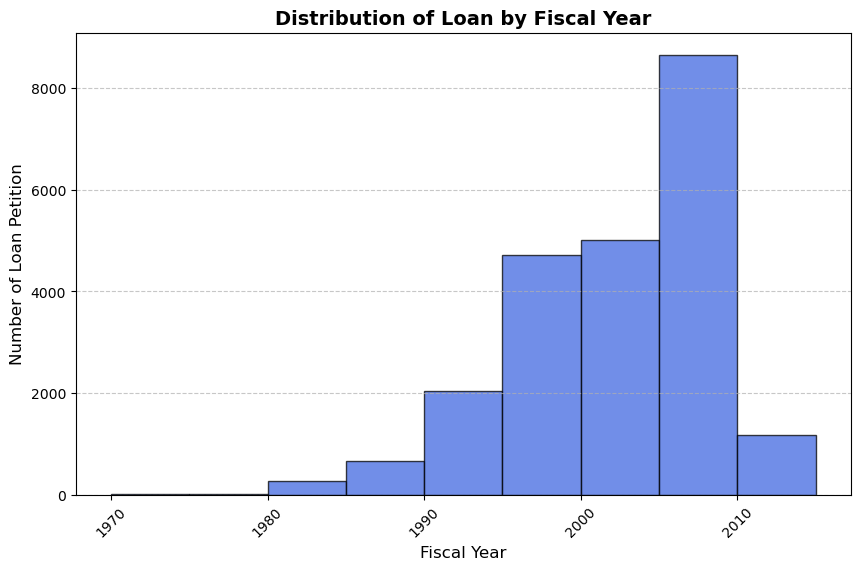

In [163]:
plt.figure(figsize=(10, 6))
plt.hist(dfc["ApprovalFY"], bins=range(int(dfc["ApprovalFY"].min()), int(dfc["ApprovalFY"].max()) + step, step),
         color="royalblue", edgecolor="black", alpha=0.75)

plt.title("Distribution of Loan by Fiscal Year", fontsize=14, fontweight='bold')
plt.xlabel("Fiscal Year", fontsize=12)
plt.ylabel("Number of Loan Petition", fontsize=12)

plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

Codificación las agrupaciones para facilitar el entrenamiento para algunos modelos

In [165]:
dfc["ApprovalFY_Grouped_cod"] = dfc["ApprovalFY_Grouped"].astype('category').cat.codes.astype('int64')
print(dfc["ApprovalFY_Grouped_cod"].value_counts())


ApprovalFY_Grouped_cod
7    8660
6    5016
5    4718
4    2048
8    1180
3     665
2     265
1      18
0       5
Name: count, dtype: int64


##### - NoEmp

Comprobación de todos los valores de la columna *NoEmp*

In [168]:
dfc['NoEmp'].value_counts()

NoEmp
1       3533
2       3025
3       1952
4       1634
5       1408
        ... 
171        1
4685       1
127        1
235        1
117        1
Name: count, Length: 189, dtype: int64

Histograma de la distribución del número de empleados, para decidir de que manera los agruparemos.

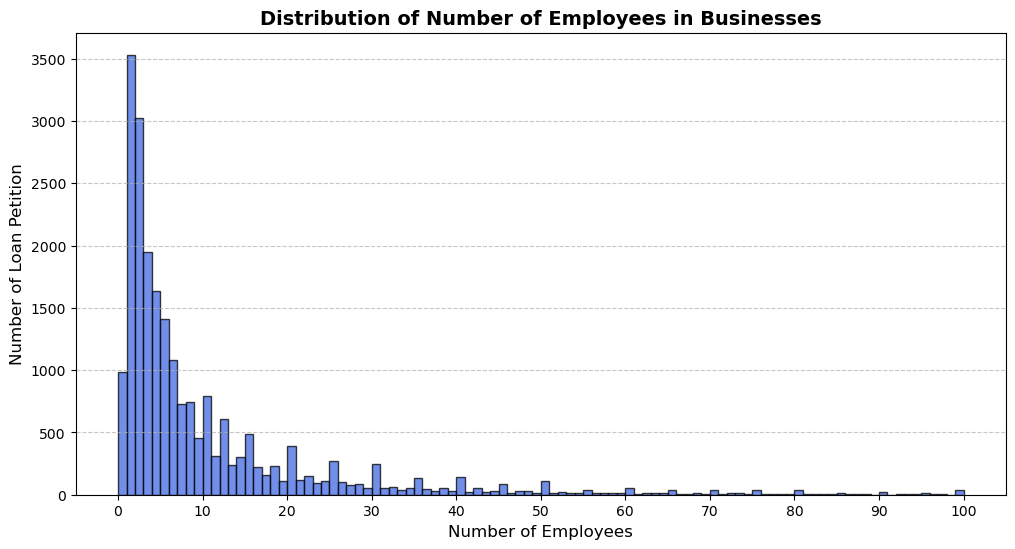

In [170]:
plt.figure(figsize=(12, 6))

plt.hist(dfc["NoEmp"], bins=range(0, 101, 1), color="royalblue", edgecolor="black", alpha=0.75)

plt.title("Distribution of Number of Employees in Businesses", fontsize=14, fontweight='bold')
plt.xlabel("Number of Employees", fontsize=12)
plt.ylabel("Number of Loan Petition", fontsize=12)

plt.xticks(range(0, 101, 10)) 
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()

Como podemos observar, se puede dividir a los diferentes empleados en varios segmentos de grupos, decidiendo.

In [172]:
# Agrupar número de empleados en las categorías especificadas
bins = [-1, 0, 2, 5, 15, np.inf]
labels = ["0", "1-2", "3-5", "6-15", "15+"]
dfc["NoEmp_Grouped"] = pd.cut(dfc["NoEmp"], bins=bins, labels=labels, right=True)

# Contar la cantidad de cada categoría
category_counts = dfc["NoEmp_Grouped"].value_counts().sort_index()

Visualizar los diferentes grupos creados para comprobar que están más o menos igualados, proporcionando información que puede llegar a ser relevante para los futuros modelos.

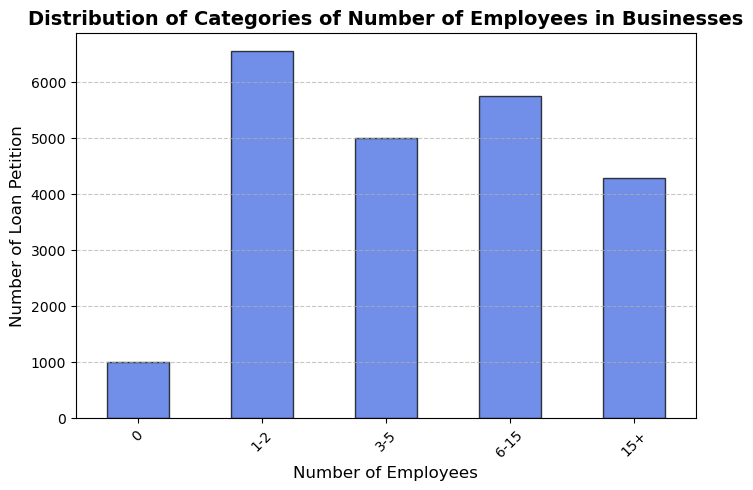

In [174]:
plt.figure(figsize=(8, 5))
category_counts.plot(kind="bar", color="royalblue", edgecolor="black", alpha=0.75)

plt.title("Distribution of Categories of Number of Employees in Businesses", fontsize=14, fontweight="bold")
plt.xlabel("Number of Employees", fontsize=12)
plt.ylabel("Number of Loan Petition", fontsize=12)

plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

Codificación de los grupos para facilitar el entrenanmiento de algunos modelos.

In [176]:
dfc["NoEmp_Grouped_cod"] = dfc["NoEmp_Grouped"].astype('category').cat.codes.astype('int64')
dfc["NoEmp_Grouped_cod"].value_counts()

NoEmp_Grouped_cod
1    6558
3    5750
2    4994
4    4286
0     987
Name: count, dtype: int64

##### - CreateJob

Comprobación de todos los valores de la columna *CreateJob*

In [179]:
dfc['CreateJob'].value_counts()

CreateJob
0      15507
1       1395
2       1366
3        742
4        570
       ...  
163        1
79         1
134        1
180        1
252        1
Name: count, Length: 88, dtype: int64

Histograma de la distribución del número de empleados, para decidir de que manera los agruparemos.

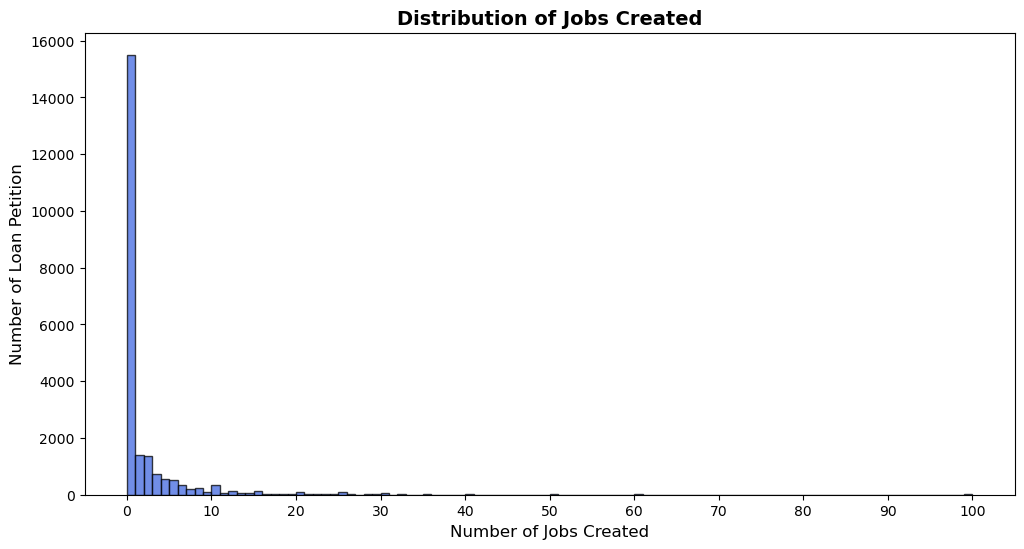

In [181]:
plt.figure(figsize=(12, 6))
plt.hist(dfc["CreateJob"], bins=range(0, 101, 1), color="royalblue", edgecolor="black", alpha=0.75)

plt.title("Distribution of Jobs Created", fontsize=14, fontweight="bold")
plt.xlabel("Number of Jobs Created", fontsize=12)
plt.ylabel("Number of Loan Petition", fontsize=12)

plt.xticks(range(0, 101, 10))
plt.show()

Al haber una diferencia muy grande entre no crear y crear trabajo lo pasaremos a binario (0-> Trabajo no creaod, 1-> Trabajo Creado)

In [183]:
# Convertir la columna 'CreateJob' en una variable binaria
dfc["CreateJob_Binary"] = dfc["CreateJob"].apply(lambda x: 0 if x == 0 else 1)

# Mostrar el conteo de cada categoría
dfc["CreateJob_Binary"].value_counts()

CreateJob_Binary
0    15507
1     7068
Name: count, dtype: int64

##### - RetainedJob

Comprobación de todos los valores de la columna *Retainedjob*

In [186]:
dfc['RetainedJob'].value_counts()

RetainedJob
0      11533
1       1944
2       1742
3       1131
4        887
       ...  
220        1
235        1
96         1
212        1
117        1
Name: count, Length: 127, dtype: int64

Histograma de la distribución del número de empleados, para decidir de que manera los agruparemos.

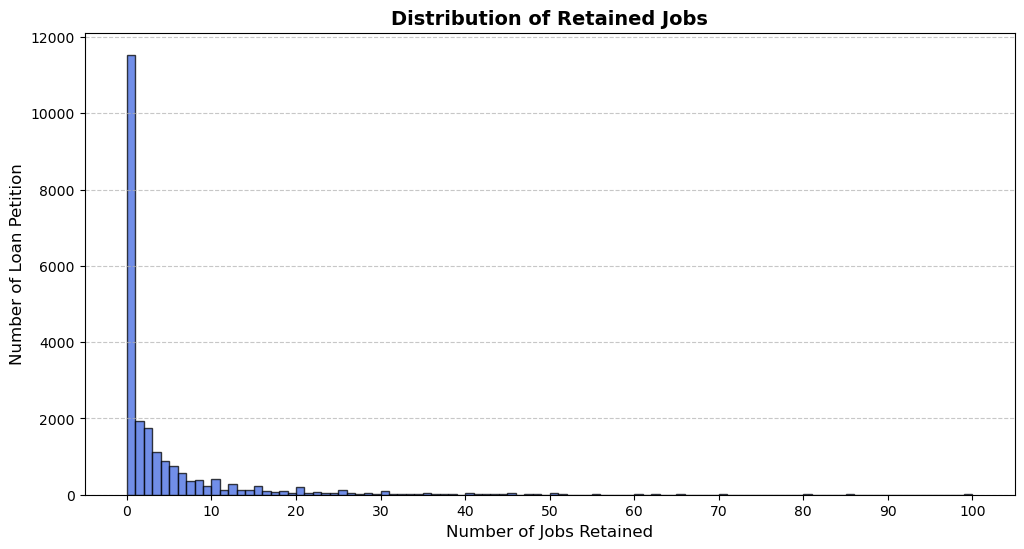

In [188]:
plt.figure(figsize=(12, 6))

plt.hist(dfc["RetainedJob"], bins=range(0, 101, 1), color="royalblue", edgecolor="black", alpha=0.75)

plt.title("Distribution of Retained Jobs", fontsize=14, fontweight="bold")
plt.xlabel("Number of Jobs Retained", fontsize=12)
plt.ylabel("Number of Loan Petition", fontsize=12)


plt.xticks(range(0, 101, 10)) 
plt.grid(axis="y", linestyle="--", alpha=0.7)  

plt.show()

Al haber una diferencia muy grande entre no mantener o mantener trabajadores lo pasaremos a binario (0-> Trabajo no mantenido, 1-> Trabajo mantenido)

In [190]:
# Convertir la columna 'CreateJob' en una variable binaria
dfc["RetainedJob_Binary"] = dfc["RetainedJob"].apply(lambda x: 0 if x == 0 else 1)

dfc["RetainedJob_Binary"].value_counts()

RetainedJob_Binary
0    11533
1    11042
Name: count, dtype: int64

##### - DisbursementGross

Comprobación de todos los valores de la columna ***DisbursementGross***

In [193]:
# print(conteo_valores["DisbursementGross"])
dfc['DisbursementGross'].value_counts()

DisbursementGross
$50,000.00      899
$100,000.00     861
$25,000.00      819
$150,000.00     479
$35,000.00      350
               ... 
$106,984.00       1
$665,100.00       1
$33,916.00        1
$29,469.00        1
$311,800.00       1
Name: count, Length: 7361, dtype: int64

Formatear los datos de ***DisbursementGross***, ya que al tener las cantidades monetarias el símbolo **'$'**, estarán en formato string. Al quitar este carácter, los podemos pasar a int.

In [195]:
dfc["DisbursementGross"] = dfc["DisbursementGross"].replace(r'[\$,]', '', regex=True).str.strip().astype(float).astype(int)

dfc["DisbursementGross"].value_counts()

DisbursementGross
50000     899
100000    861
25000     819
150000    479
35000     350
         ... 
106984      1
665100      1
33916       1
29469       1
311800      1
Name: count, Length: 7361, dtype: int64

Agrupar las diferentes cantidades de dinero por si pueden llegar a proporcionar información de manera más sencilla.

In [197]:
# Definir nuevos límites (bins) basados en la distribución analizada
bins = [-1, 30000, 75000, 150000, 500000, np.inf]
labels = ["0-30k", "30k-75k", "75k-150k", "150k-500k", "500k+"]

# Agrupar según los rangos definidos
dfc["DisbursementGross_Grouped"] = pd.cut(dfc["DisbursementGross"], bins=bins, labels=labels, right=True)

# Mostrar el conteo por cada rango
print(dfc["DisbursementGross_Grouped"].value_counts())


DisbursementGross_Grouped
30k-75k      6048
75k-150k     5536
150k-500k    5179
0-30k        4252
500k+        1560
Name: count, dtype: int64


Codificaremos los diferentes ***DisbursementGross_Grouped*** para facilitar el entrenamiento en determinados modelos.

In [199]:
dfc["DisbursementGross_Grouped_cod"] = dfc["DisbursementGross_Grouped"].astype('category').cat.codes.astype('int64')
dfc["DisbursementGross_Grouped_cod"].value_counts()

DisbursementGross_Grouped_cod
1    6048
2    5536
3    5179
0    4252
4    1560
Name: count, dtype: int64

# 5. Correlacion

Creación de un nuevo ***DataFrame*** a partir del ***DataFrame train*** tratado para no modificar el original.

In [202]:
dfn = dfc.copy()
dfn.dtypes

ApprovalDate                        int64
ApprovalFY                          int32
NoEmp                               int64
CreateJob                           int64
RetainedJob                         int64
DisbursementDate                    int64
DisbursementGross                   int32
Accept                              int64
NewExist_Binary                     int64
Franchise_Binary                    int32
UrbanRural_Binary                   int64
RevLineCr_Binary                    int64
LowDoc_Binary                       int64
ApprovalDate_quarter                int32
DisbursementDate_quarter            int32
Bank_Categorized                   object
Bank_Categorized_cod                int64
BankState_Categorized              object
BankState_Categorized_cod           int64
ApprovalFY_Grouped                 object
ApprovalFY_Grouped_cod              int64
NoEmp_Grouped                    category
NoEmp_Grouped_cod                   int64
CreateJob_Binary                  

Extraer del *dataframe* creado a lo largo del *notebook* solo los parámetros de tipo ***Int***.

In [204]:
dfn = dfn.select_dtypes(include=[int]) 
dfn.dtypes


ApprovalDate                     int64
ApprovalFY                       int32
NoEmp                            int64
CreateJob                        int64
RetainedJob                      int64
DisbursementDate                 int64
DisbursementGross                int32
Accept                           int64
NewExist_Binary                  int64
Franchise_Binary                 int32
UrbanRural_Binary                int64
RevLineCr_Binary                 int64
LowDoc_Binary                    int64
ApprovalDate_quarter             int32
DisbursementDate_quarter         int32
Bank_Categorized_cod             int64
BankState_Categorized_cod        int64
ApprovalFY_Grouped_cod           int64
NoEmp_Grouped_cod                int64
CreateJob_Binary                 int64
RetainedJob_Binary               int64
DisbursementGross_Grouped_cod    int64
dtype: object

Calcular y mostrar matriz de correlación del *dataframe* ***train***

In [206]:
corrMatrix = dfn.corr()
print(corrMatrix)

                               ApprovalDate  ApprovalFY     NoEmp  CreateJob  \
ApprovalDate                       1.000000    0.003570  0.005026   0.019193   
ApprovalFY                         0.003570    1.000000 -0.080918  -0.109155   
NoEmp                              0.005026   -0.080918  1.000000   0.014674   
CreateJob                          0.019193   -0.109155  0.014674   1.000000   
RetainedJob                        0.019312   -0.106402  0.018788   0.998855   
DisbursementDate                   0.254538    0.036296 -0.005554   0.006650   
DisbursementGross                  0.020210   -0.063986  0.106553   0.003387   
Accept                             0.005163   -0.154456  0.034753   0.011666   
NewExist_Binary                    0.008390   -0.030607  0.052638   0.022865   
Franchise_Binary                   0.012765   -0.038774  0.016045  -0.002413   
UrbanRural_Binary                  0.008538   -0.265475  0.024546   0.019209   
RevLineCr_Binary                  -0.008

Visualización de la matriz de correlación una vez realizado ***One-Hot*** a través de un mapa de calor.

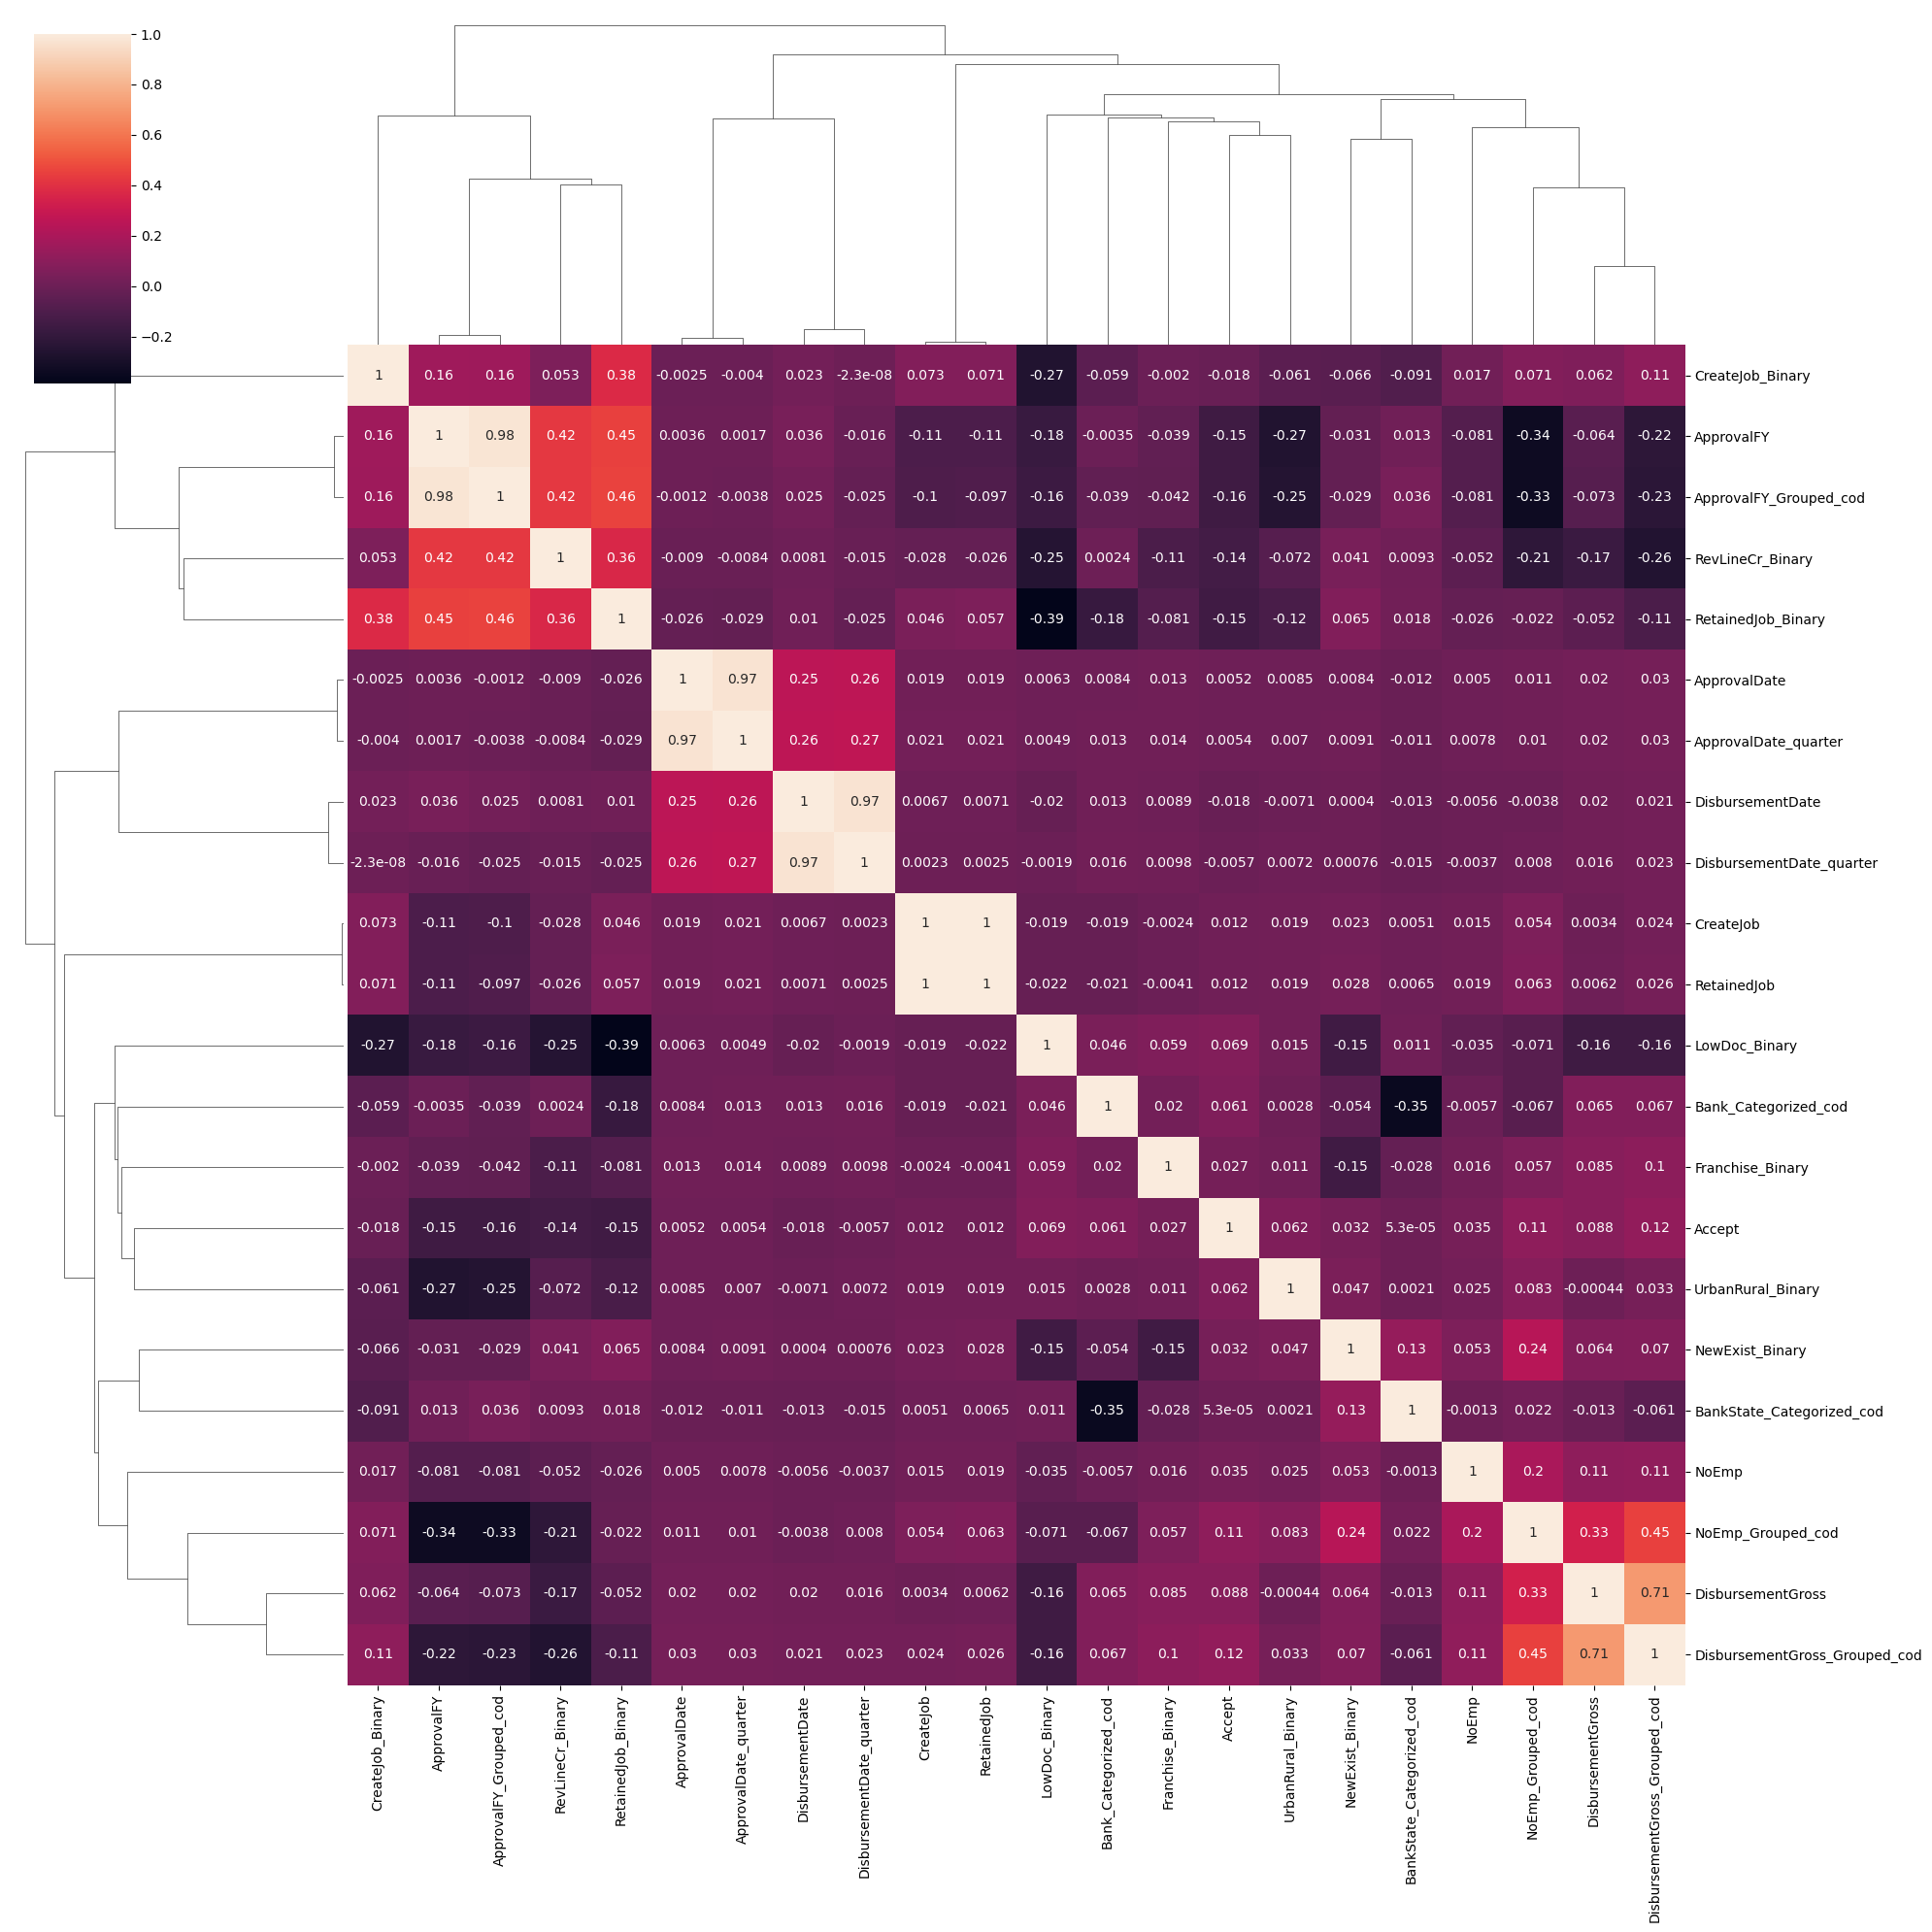

In [208]:
sns.clustermap(corrMatrix, annot=True, figsize=(20,20))
plt.show()

> Las diferentes caractríticas de interés serán seleccionadas a la hora de realizar los diferentes modelos.

# 6. Codificacion One-Hot 

Realización de One-Hot para los atributos ***BankState_Categorized*** y ***Bank_Categorized***

In [212]:
dfa = dfc.copy() # Backup del dataframe original
dfc = pd.get_dummies(dfc, columns=['Bank_Categorized'], prefix='Bank', dtype=int)
dfc = pd.get_dummies(dfc, columns=['BankState_Categorized'], prefix='BankState', dtype=int)
dfc['Bank_Categorized'] = dfa['Bank_Categorized'].values
dfc['BankState_Categorized'] = dfa['BankState_Categorized'].values
# Verificar las nuevas columnas creadas
dfc.columns



Index(['ApprovalDate', 'ApprovalFY', 'NoEmp', 'CreateJob', 'RetainedJob',
       'DisbursementDate', 'DisbursementGross', 'Accept', 'NewExist_Binary',
       'Franchise_Binary', 'UrbanRural_Binary', 'RevLineCr_Binary',
       'LowDoc_Binary', 'ApprovalDate_quarter', 'DisbursementDate_quarter',
       'Bank_Categorized_cod', 'BankState_Categorized_cod',
       'ApprovalFY_Grouped', 'ApprovalFY_Grouped_cod', 'NoEmp_Grouped',
       'NoEmp_Grouped_cod', 'CreateJob_Binary', 'RetainedJob_Binary',
       'DisbursementGross_Grouped', 'DisbursementGross_Grouped_cod',
       'Bank_CAPITAL ONE NATL ASSOC', 'Bank_CITIZENS BANK NATL ASSOC',
       'Bank_COMMUNITY CAP. DEVEL CORP', 'Bank_FIFTH THIRD BANK',
       'Bank_FIRSTMERIT BANK, N.A.', 'Bank_HAMILTON CNTY DEVEL COMPANY IN',
       'Bank_JPMORGAN CHASE BANK NATL ASSOC',
       'Bank_KEYBANK NATIONAL ASSOCIATION', 'Bank_Otros',
       'Bank_PNC BANK, NATIONAL ASSOCIATION',
       'Bank_THE HUNTINGTON NATIONAL BANK',
       'Bank_U.S. BANK NATI

Visualizar en la tabla de *dataset* el proceso realizado

In [214]:
dfc.head()

,ApprovalDate,ApprovalFY,NoEmp,CreateJob,RetainedJob,DisbursementDate,DisbursementGross,Accept,NewExist_Binary,Franchise_Binary,UrbanRural_Binary,RevLineCr_Binary,LowDoc_Binary,ApprovalDate_quarter,DisbursementDate_quarter,Bank_Categorized_cod,BankState_Categorized_cod,ApprovalFY_Grouped,ApprovalFY_Grouped_cod,NoEmp_Grouped,NoEmp_Grouped_cod,CreateJob_Binary,RetainedJob_Binary,DisbursementGross_Grouped,DisbursementGross_Grouped_cod,Bank_CAPITAL ONE NATL ASSOC,Bank_CITIZENS BANK NATL ASSOC,Bank_COMMUNITY CAP. DEVEL CORP,Bank_FIFTH THIRD BANK,"Bank_FIRSTMERIT BANK, N.A.",Bank_HAMILTON CNTY DEVEL COMPANY IN,Bank_JPMORGAN CHASE BANK NATL ASSOC,Bank_KEYBANK NATIONAL ASSOCIATION,Bank_Otros,"Bank_PNC BANK, NATIONAL ASSOCIATION",Bank_THE HUNTINGTON NATIONAL BANK,Bank_U.S. BANK NATIONAL ASSOCIATION,Bank_WELLS FARGO BANK NATL ASSOC,BankState_CA,BankState_DE,BankState_IL,BankState_IN,BankState_OH,BankState_Otros,BankState_RI,BankState_SD,BankState_VA,Bank_Categorized,BankState_Categorized
0,11,2006,2,0,2,12,8000,1,0,0,1,0,0,4,4,1,6,2005-2009,7,1-2,1,0,1,0-30k,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,CITIZENS BANK NATL ASSOC,RI
1,6,2005,2,1,2,7,166000,1,0,0,1,0,0,2,3,4,4,2005-2009,7,1-2,1,1,1,150k-500k,3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,"FIRSTMERIT BANK, N.A.",OH
2,3,2003,2,4,2,3,25000,1,0,0,0,1,0,1,1,9,4,2000-2004,6,1-2,1,1,1,0-30k,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,"PNC BANK, NATIONAL ASSOCIATION",OH
3,6,1995,2,0,0,1,220100,1,0,0,1,0,0,2,1,10,4,1995-1999,5,1-2,1,0,0,150k-500k,3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,THE HUNTINGTON NATIONAL BANK,OH
4,4,2009,0,0,0,5,25000,0,1,0,1,0,0,2,2,10,4,2005-2009,7,0,0,0,0,0-30k,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,THE HUNTINGTON NATIONAL BANK,OH


Visualización de la matriz de correlación una vez realizado ***One-Hot*** a través de un mapa de calor.

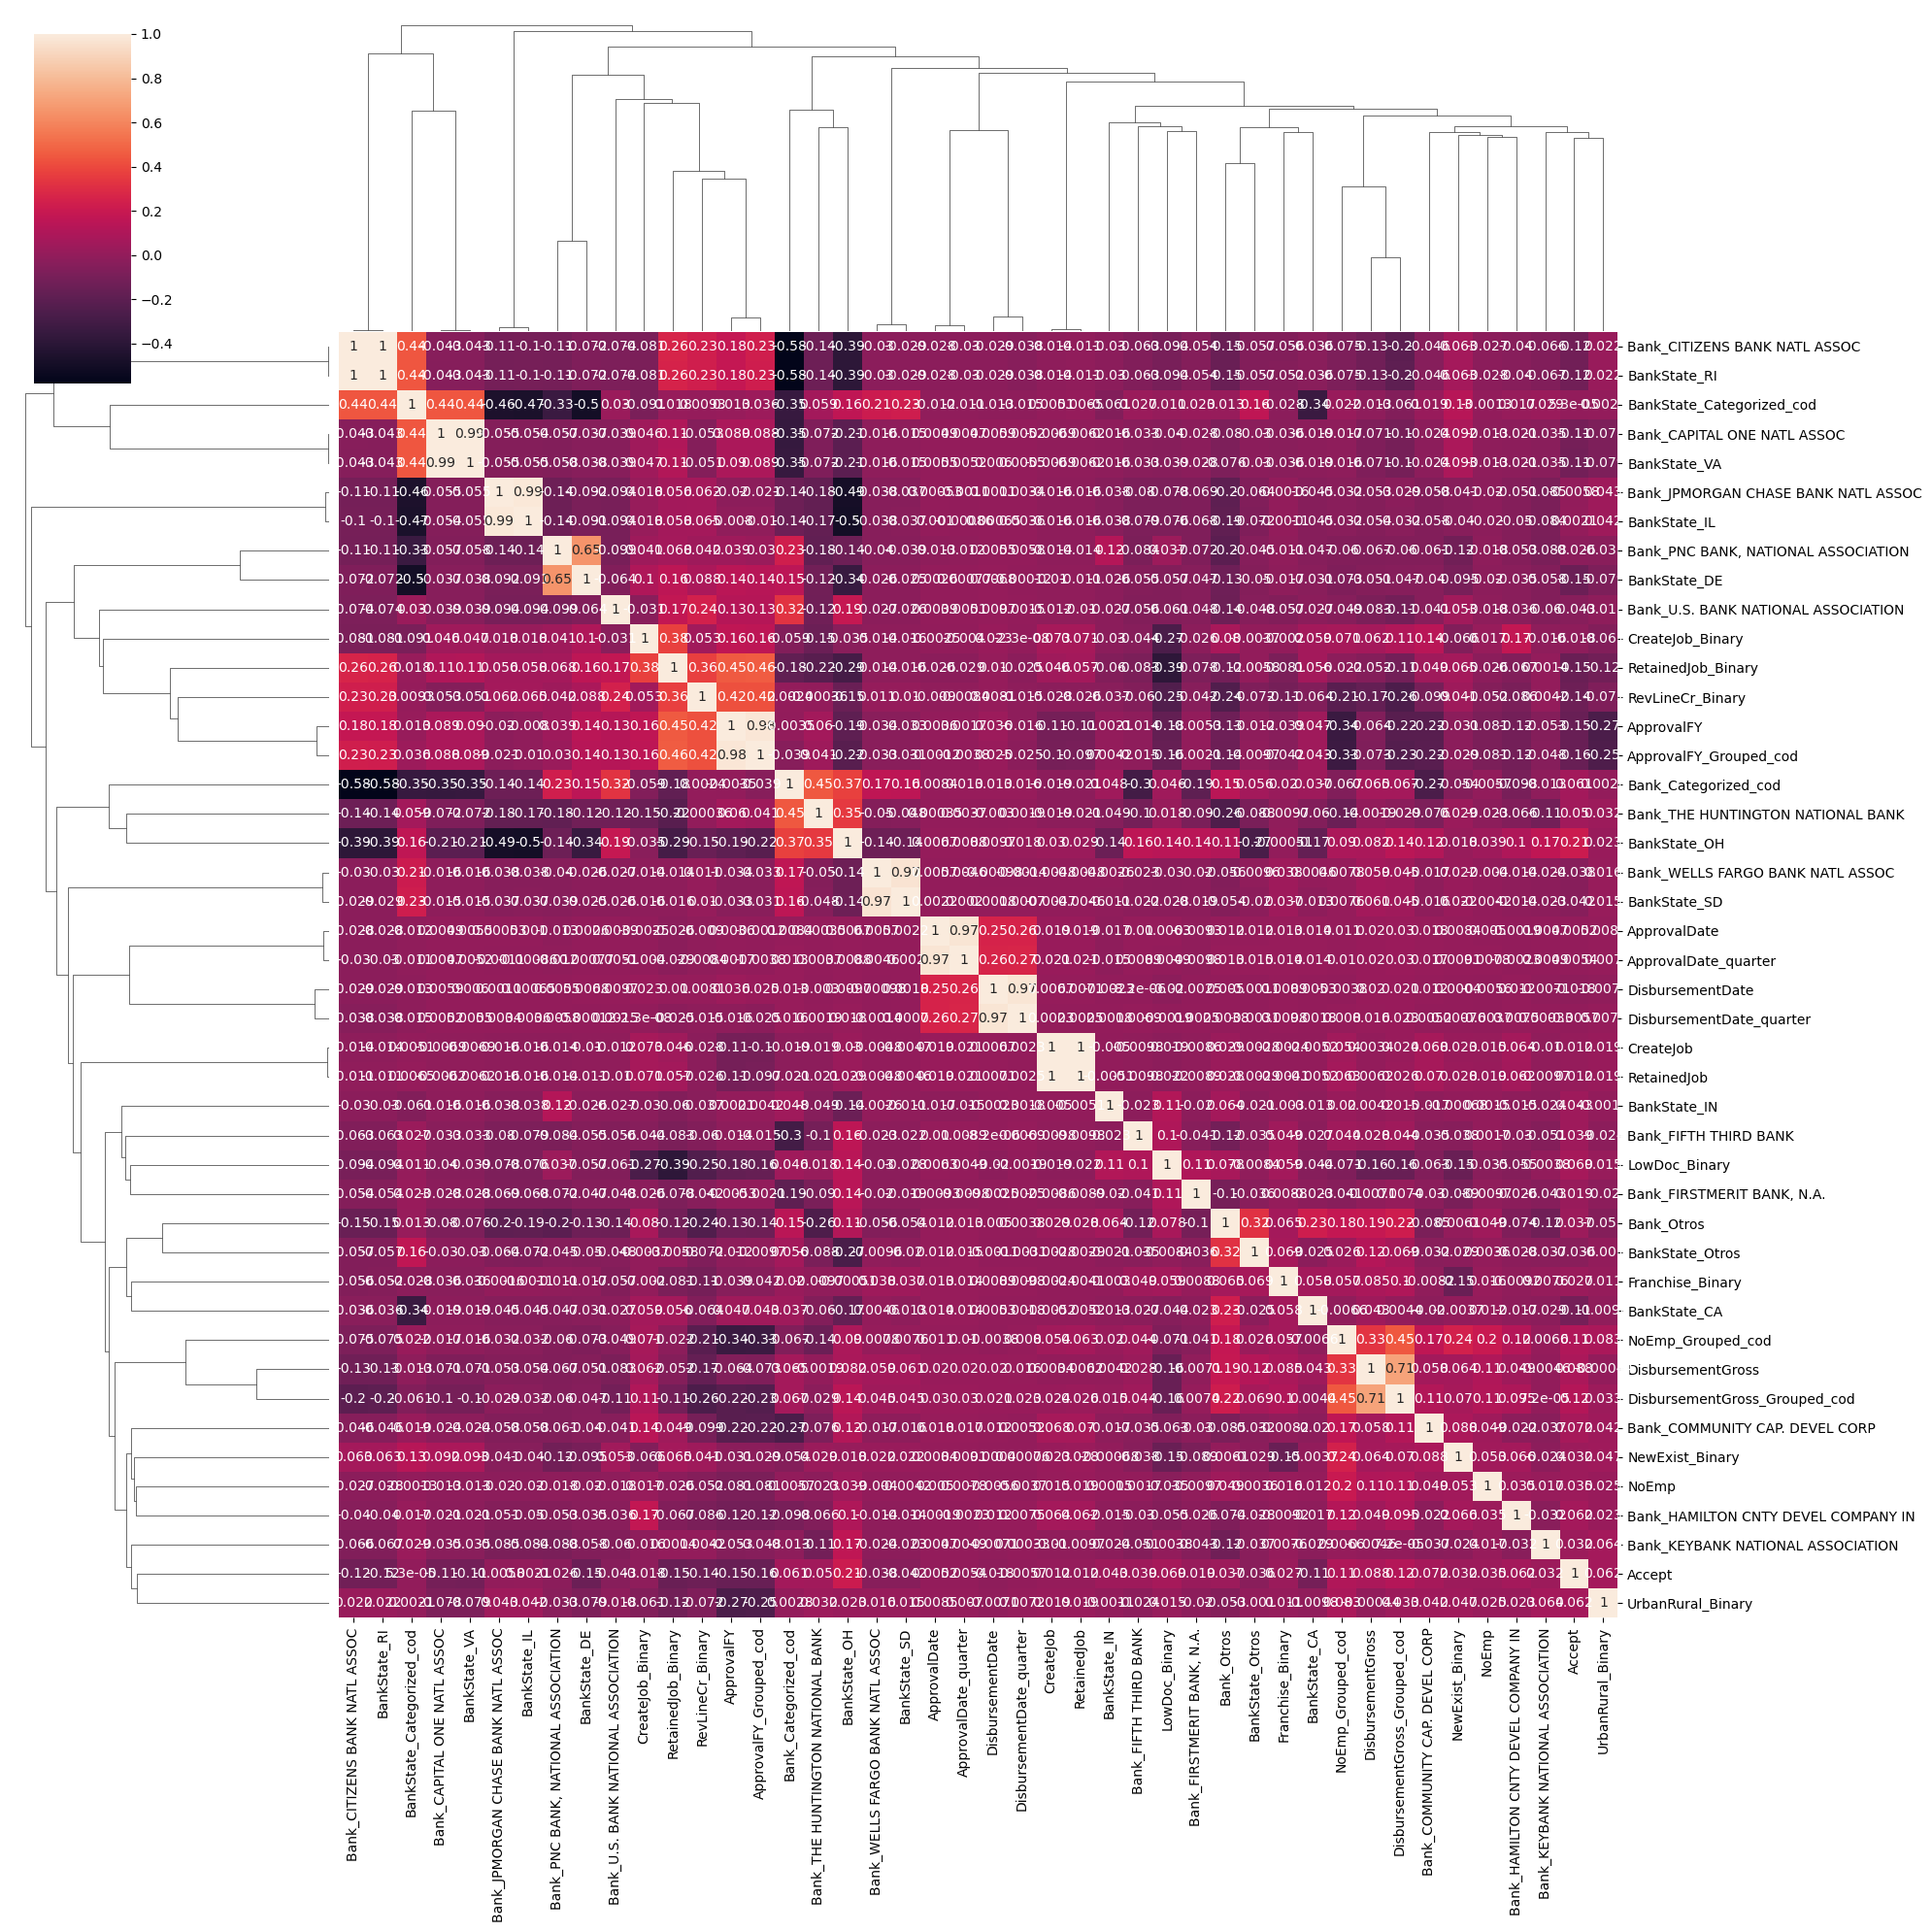

In [216]:
dfn = dfc.select_dtypes(include=[int]) 
corrMatrixa = dfn.corr()
sns.clustermap(corrMatrixa, annot=True, figsize=(20, 20)) 
plt.show()

# 7. Create Test

In [218]:
dfa.dtypes.sort_index()

Accept                              int64
ApprovalDate                        int64
ApprovalDate_quarter                int32
ApprovalFY                          int32
ApprovalFY_Grouped                 object
ApprovalFY_Grouped_cod              int64
BankState_Categorized              object
BankState_Categorized_cod           int64
Bank_Categorized                   object
Bank_Categorized_cod                int64
CreateJob                           int64
CreateJob_Binary                    int64
DisbursementDate                    int64
DisbursementDate_quarter            int32
DisbursementGross                   int32
DisbursementGross_Grouped        category
DisbursementGross_Grouped_cod       int64
Franchise_Binary                    int32
LowDoc_Binary                       int64
NewExist_Binary                     int64
NoEmp                               int64
NoEmp_Grouped                    category
NoEmp_Grouped_cod                   int64
RetainedJob                       

In [219]:
# Opcional: Eliminar filas con valores nulos en el DataFrame 'df_test'
# df_test = df_test.dropna()

# # Mostrar la cantidad de valores nulos restantes en 'df_test'
print(df_test.isnull().sum())

id                   0
LoanNr_ChkDgt        0
Name                 0
City                 0
State                0
Bank                 5
BankState            5
ApprovalDate         0
ApprovalFY           0
NoEmp                0
NewExist             0
CreateJob            0
RetainedJob          0
FranchiseCode        0
UrbanRural           0
RevLineCr            4
LowDoc               9
DisbursementDate     7
DisbursementGross    0
BalanceGross         0
dtype: int64


Eliminar elementos que no queramos del dataframe test, pero aqui si queremos los id para kaggel

In [221]:
# Eliminar la columna 'id' del DataFrame 'featuresUseless'
featuresUselessWithoutId = featuresUseless.copy()
featuresUselessWithoutId.remove('id')
df_test = df_test.drop(columns=featuresUselessWithoutId)

# Verificar los tipos de datos de las columnas
df_test.dtypes
df_testn = df_test.copy()


Limpiar y estandarizar todos los atributos para que sea igual que el *dataset* ***train***

In [223]:
##############
## Binarias 
##############
### NewExist_Binary                     int64

df_testn['NewExist_Binary'] = df_testn['NewExist'].replace({
    1.0: 1, 
    0.0: 1, 
    2.0: 0, 
})

df_testn['NewExist_Binary'] = df_testn['NewExist_Binary'].astype('int64')
print(df_testn['NewExist_Binary'].value_counts())
df_testn = df_testn.drop(columns=['NewExist'])


## Franchise_Binary                    int64
df_testn['Franchise_Binary'] = np.where(df_testn['FranchiseCode'].isin([0, 1]), 0, 1)
df_testn = df_testn.drop(columns=['FranchiseCode'])

### UrbanRural_Binary                   int64
df_testn['UrbanRural_Binary'] = df_testn['UrbanRural'].replace({
    0: 1    
})

df_testn['UrbanRural_Binary'] = df_testn['UrbanRural_Binary'].replace({
    1: 1,
    2: 0    
})
df_testn = df_testn.drop(columns=['UrbanRural'])

### RevLineCr_Binary                    int64
category_map = {'Y': 1, 'T': 1, 'N': 0, '0': 0}

df_testn['RevLineCr'] = df_testn['RevLineCr'].fillna('N')
df_testn['RevLineCr_Binary'] = df_testn['RevLineCr'].map(category_map).astype(float).astype(int)
df_testn = df_testn.drop(columns=['RevLineCr'])

## LowDoc_Binary                       int64
df_testn['LowDoc'] = df_testn['LowDoc'].fillna('N')
df_testn.loc[~df_testn['LowDoc'].isin(['Y', 'N', '0']), 'LowDoc'] = 'N'
df_testn['LowDoc'] = df_testn['LowDoc'].replace('0', 'N')
df_testn['LowDoc_Binary'] = df_testn['LowDoc'].map({'Y': 1, 'N': 0})
df_testn = df_testn.drop(columns=['LowDoc'])

NewExist_Binary
1    2248
0    1036
Name: count, dtype: int64


In [224]:
##############
## Fechas
##############
### ApprovalDate                        int64
### ApprovalDate_quarter                int64
df_testn['ApprovalDate'] = df_testn['ApprovalDate'].apply(extract_month)
df_testn['ApprovalDate_quarter'] = df_testn['ApprovalDate'].apply(month_to_quarter)

# ### DisbursementDate                    int64
# ### DisbursementDate_quarter            int64
df_testn['DisbursementDate'] = df_testn['DisbursementDate'].apply(lambda x: extract_month(x, mode=4))
df_testn['DisbursementDate_quarter'] = df_testn['DisbursementDate'].apply(month_to_quarter)



In [225]:
##############
## Categorías
##############
### Bank_Categorized                   object
### Bank_Categorized_cod                int64

df_testn['Bank'] = df_testn['Bank'].fillna("THE HUNTINGTON NATIONAL BANK")
categorias_existentes = top_12_banks  
df_testn["Bank_Categorized"] = df_testn["Bank"].apply(lambda x: x if x in categorias_existentes else "Otros")
df_testn["Bank_Categorized_cod"] = df_testn["Bank_Categorized"].astype('category').cat.codes.astype('int64')

# # #-### Bank_OneHot
dfk =  df_testn.copy()
df_testn = pd.get_dummies(df_testn, columns=['Bank_Categorized'], prefix='Bank', dtype=int)
df_testn['Bank_Categorized'] = dfk['Bank_Categorized'].values

df_testn = df_testn.drop(columns=['Bank'])

# ### BankState_Categorized              object
# ### BankState_Categorized_cod           int64

# # BankState
df_testn['BankState'] = df_testn['BankState'].fillna("OH")

# Crear la nueva columna categorizada
df_testn["BankState_Categorized"] = df_testn["BankState"].apply(lambda x: x if x in top_8_bank_states else "Otros")

df_testn["BankState_Categorized_cod"] = df_testn["BankState_Categorized"].astype('category').cat.codes.astype('int64')


df_testn = df_testn.drop(columns=['BankState'])

# # #-### BankState_OneHot
dfk =  df_testn.copy()

df_testn = pd.get_dummies(df_testn, columns=['BankState_Categorized'], prefix='BankState', dtype=int)
df_testn['BankState_Categorized'] = dfk['BankState_Categorized'].values


# ### ApprovalFY                          int64
# ### ApprovalFY_Grouped                 category
# ### ApprovalFY_Grouped_cod              int64
df_testn['ApprovalFY'] = df_testn['ApprovalFY'].astype(str).str.extract(r'(\d{4})')  # Extraer solo los años
df_testn['ApprovalFY'] = df_testn['ApprovalFY'].astype(float).astype(int)  # Convertir a entero

step = 5
start_year = 1970
dfc["ApprovalFY_Grouped"] = dfc["ApprovalFY"].apply(
    lambda year: f"{((year - start_year) // step) * step + start_year}-"
                 f"{((year - start_year) // step) * step + start_year + step - 1}"
)

df_testn["ApprovalFY_Grouped"] = df_testn["ApprovalFY"].apply(
    lambda year: f"{(year // step) * step}-{(year // step) * step + step - 1}"
)
df_testn["ApprovalFY_Grouped_cod"] = df_testn["ApprovalFY_Grouped"].astype('category').cat.codes.astype('int64')


# ### NoEmp                               int64
# ### NoEmp_Grouped                    category
# ### NoEmp_Grouped_cod                   int64
bins = [-1, 0, 2, 5, 15, np.inf]
labels = ["0", "1-2", "3-5", "6-15", "15+"]
df_testn["NoEmp_Grouped"] = pd.cut(df_testn["NoEmp"], bins=bins, labels=labels, right=True)
category_counts = df_testn["NoEmp_Grouped"].value_counts().sort_index()

df_testn["NoEmp_Grouped_cod"] = df_testn["NoEmp_Grouped"].astype('category').cat.codes.astype('int64')


# ### CreateJob                           int64
# ### CreateJob_Binary                    int64
df_testn["CreateJob_Binary"] = df_testn["CreateJob"].apply(lambda x: 0 if x == 0 else 1)


# ### RetainedJob                         int64
# ### RetainedJob_Binary                  int64
df_testn["RetainedJob_Binary"] = df_testn["RetainedJob"].apply(lambda x: 0 if x == 0 else 1)


# ### DisbursementGross                   int64
# ### DisbursementGross_Grouped        category
# ### DisbursementGross_Grouped_cod       int64
df_testn["DisbursementGross"] = df_testn["DisbursementGross"].replace(r'[\$,]', '', regex=True).str.strip().astype(float).astype(int)

bins = [-1, 30000, 75000, 150000, 500000, np.inf]
labels = ["0-30k", "30k-75k", "75k-150k", "150k-500k", "500k+"]
df_testn["DisbursementGross_Grouped"] = pd.cut(df_testn["DisbursementGross"], bins=bins, labels=labels, right=True)
df_testn["DisbursementGross_Grouped_cod"] = df_testn["DisbursementGross_Grouped"].astype('category').cat.codes.astype('int64')

In [226]:
df_testn.dtypes.sort_index()

ApprovalDate                              int64
ApprovalDate_quarter                      int32
ApprovalFY                                int32
ApprovalFY_Grouped                       object
ApprovalFY_Grouped_cod                    int64
BankState_CA                              int32
BankState_Categorized                    object
BankState_Categorized_cod                 int64
BankState_DE                              int32
BankState_IL                              int32
BankState_IN                              int32
BankState_OH                              int32
BankState_Otros                           int32
BankState_RI                              int32
BankState_SD                              int32
BankState_VA                              int32
Bank_CAPITAL ONE NATL ASSOC               int32
Bank_CITIZENS BANK NATL ASSOC             int32
Bank_COMMUNITY CAP. DEVEL CORP            int32
Bank_Categorized                         object
Bank_Categorized_cod                    

In [227]:
print(df_testn.isnull().sum().to_string())
print(df_testn.shape)
print(dfc.shape)

id                                     0
ApprovalDate                           0
ApprovalFY                             0
NoEmp                                  0
CreateJob                              0
RetainedJob                            0
DisbursementDate                       0
DisbursementGross                      0
NewExist_Binary                        0
Franchise_Binary                       0
UrbanRural_Binary                      0
RevLineCr_Binary                       0
LowDoc_Binary                          0
ApprovalDate_quarter                   0
DisbursementDate_quarter               0
Bank_Categorized_cod                   0
Bank_CAPITAL ONE NATL ASSOC            0
Bank_CITIZENS BANK NATL ASSOC          0
Bank_COMMUNITY CAP. DEVEL CORP         0
Bank_FIFTH THIRD BANK                  0
Bank_FIRSTMERIT BANK, N.A.             0
Bank_HAMILTON CNTY DEVEL COMPANY IN    0
Bank_JPMORGAN CHASE BANK NATL ASSOC    0
Bank_KEYBANK NATIONAL ASSOCIATION      0
Bank_Otros      

In [228]:
print(df_testn.shape)
df_testn.info()

(3284, 49)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3284 entries, 0 to 3283
Data columns (total 49 columns):
 #   Column                               Non-Null Count  Dtype   
---  ------                               --------------  -----   
 0   id                                   3284 non-null   object  
 1   ApprovalDate                         3284 non-null   int64   
 2   ApprovalFY                           3284 non-null   int32   
 3   NoEmp                                3284 non-null   int64   
 4   CreateJob                            3284 non-null   int64   
 5   RetainedJob                          3284 non-null   int64   
 6   DisbursementDate                     3284 non-null   int64   
 7   DisbursementGross                    3284 non-null   int32   
 8   NewExist_Binary                      3284 non-null   int64   
 9   Franchise_Binary                     3284 non-null   int32   
 10  UrbanRural_Binary                    3284 non-null   int64   
 11  RevLin

# 8. Exportar CSV

Comparar los dos dataset para ver que todo esta bien

In [231]:
df_check =  pd.read_csv("data/test_nolabel.csv")

In [232]:
# Comparar las columnas de dfc y df_testn
columns_dfc = set(dfc.columns)
columns_df_testn = set(df_testn.columns)

# Encontrar las diferencias
differences = columns_dfc.symmetric_difference(columns_df_testn)

# Verificar si la única diferencia es 'id'
if differences == {'id', 'Accept'}:
    print("La única diferencia entre las columnas es 'id' y 'Accept'.")
else:
    print("Existen otras diferencias en las columnas:", differences)

La única diferencia entre las columnas es 'id' y 'Accept'.


Guardar en *formated* los csv train y test

In [234]:
# Exportar el DataFrame 'dfn' a un archivo CSV
dfc.to_csv('./formated/train_exportado_v2.csv', index=False)

df_testn.to_csv('./formated/test_exportado_v2.csv', index=False)

Todas las features:

In [236]:
all_features = [
    # Características numéricas
    'ApprovalFY', 'NoEmp', 'CreateJob', 'RetainedJob', 'DisbursementGross',

    # Características categóricas binarias
    'NewExist_Binary', 'Franchise_Binary', 'UrbanRural_Binary',
    'RevLineCr_Binary', 'LowDoc_Binary', 'CreateJob_Binary',
    'RetainedJob_Binary',

    # Características categóricas codificadas
    'ApprovalFY_Grouped_cod', 'NoEmp_Grouped_cod', 
    'DisbursementGross_Grouped_cod',

    # Características temporales
    'ApprovalDate', 'DisbursementDate', 
    'ApprovalDate_quarter', 'DisbursementDate_quarter',

    # Características categóricas sin codificar
    'Bank_Categorized_cod', 'BankState_Categorized_cod',
    'ApprovalFY_Grouped', 'NoEmp_Grouped', 
    'DisbursementGross_Grouped',

    # Características relacionadas con Bank tras un One Hot Encoding
    'Bank_CAPITAL ONE NATL ASSOC', 'Bank_CITIZENS BANK NATL ASSOC',
    'Bank_COMMUNITY CAP. DEVEL CORP', 'Bank_FIFTH THIRD BANK',
    'Bank_FIRSTMERIT BANK, N.A.', 'Bank_HAMILTON CNTY DEVEL COMPANY IN',
    'Bank_JPMORGAN CHASE BANK NATL ASSOC',
    'Bank_KEYBANK NATIONAL ASSOCIATION', 'Bank_Otros',
    'Bank_PNC BANK, NATIONAL ASSOCIATION',
    'Bank_THE HUNTINGTON NATIONAL BANK',
    'Bank_U.S. BANK NATIONAL ASSOCIATION',
    'Bank_WELLS FARGO BANK NATL ASSOC',

    # Características relacionadas con BankState tras un One Hot Encoding
    'BankState_CA', 'BankState_DE', 'BankState_IL', 'BankState_IN',
    'BankState_OH', 'BankState_Otros', 'BankState_RI', 
    'BankState_SD', 'BankState_VA',
]


# 9. Referencias

* [Alexisbcook. (2023, 21 abril). Categorical variables. Kaggle.](https://www.kaggle.com/code/alexisbcook/categorical-variables)
* [pandas documentation — pandas 2.2.3 documentation. (s. f.).](https://pandas.pydata.org/docs/)